In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean_location.xlsx')
df['Location'] = df['Location'].str.strip()
df.loc[df['Location'].eq('Faro') & df['Screening_date'].eq('2022-08-13'), 'Screening_date'] = '2022-08-14'
df.loc[df['Location'].eq('Lisboa') & df['Screening_date'].eq('2023-05-15'), 'Screening_date'] = '2023-05-19'

df.head()

## Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

d1 = df.groupby(['Location', 'Screening_date'], as_index=False).size().sort_values(['Location', 'Screening_date'])
d2 = d1.assign(count = d1.groupby(['Location'])['Location'].transform('count'))
d2 = d2[d2['count'].ne(1)]

d2['ndays'] = d2.groupby('Location')['Screening_date'].diff()
d2['nscreens'] = d2['size'].values/d2['ndays'].dt.days
d2

date_range = pd.date_range(start='2022-03-03', end='2024-04-20') #datas mais extremas no dataset

datesdf = pd.DataFrame(date_range, columns=['Screening_date'])

list_dfs = []

groups = d2.groupby('Location')

for _, group in groups:
    list_dfs.append(datesdf.merge(group, how='left').bfill().ffill())

d3 = pd.concat(list_dfs)
d3

# Agrupar por 'Screening_date' e somar a coluna 'nscreens'
d4 = d3.groupby('Screening_date', as_index=False)['nscreens'].sum()

# Exibir o resultado
print(d4)

    Screening_date   nscreens
0       2022-03-03  11.169861
1       2022-03-04  11.169861
2       2022-03-05  11.169861
3       2022-03-06  11.169861
4       2022-03-07  11.169861
..             ...        ...
775     2024-04-16  12.874846
776     2024-04-17  12.874846
777     2024-04-18  12.874846
778     2024-04-19  12.874846
779     2024-04-20  12.874846

[780 rows x 2 columns]


ADD DATE RELATED VARIABLES

In [3]:
# Criar variável de tendência linear
d4['days_since_start'] = (d4['Screening_date'] - d4['Screening_date'].min()).dt.days

# Se houver um padrão sazonal claro, você pode criar variáveis sazonais
# Por exemplo, seno e cosseno para capturar padrões sazonais anuais
d4['sin_seasonal'] = np.sin(2 * np.pi * d4['days_since_start'] / 365.25)
d4['cos_seasonal'] = np.cos(2 * np.pi * d4['days_since_start'] / 365.25)

In [4]:
d4

,Screening_date,nscreens,days_since_start,sin_seasonal,cos_seasonal
0,2022-03-03,11.169861,0,0.000000,1.000000
1,2022-03-04,11.169861,1,0.017202,0.999852
2,2022-03-05,11.169861,2,0.034398,0.999408
3,2022-03-06,11.169861,3,0.051584,0.998669
4,2022-03-07,11.169861,4,0.068755,0.997634
...,...,...,...,...,...
775,2024-04-16,12.874846,775,0.692903,0.721031
776,2024-04-17,12.874846,776,0.705204,0.709005
777,2024-04-18,12.874846,777,0.717295,0.696769
778,2024-04-19,12.874846,778,0.729175,0.684328


CORRELAÇÃO VVS

                  Screening_date  nscreens  days_since_start  sin_seasonal  \
Screening_date          1.000000 -0.084516          1.000000     -0.289133   
nscreens               -0.084516  1.000000         -0.084516      0.298890   
days_since_start        1.000000 -0.084516          1.000000     -0.289133   
sin_seasonal           -0.289133  0.298890         -0.289133      1.000000   
cos_seasonal            0.123695  0.413998          0.123695      0.038901   

                  cos_seasonal  
Screening_date        0.123695  
nscreens              0.413998  
days_since_start      0.123695  
sin_seasonal          0.038901  
cos_seasonal          1.000000  


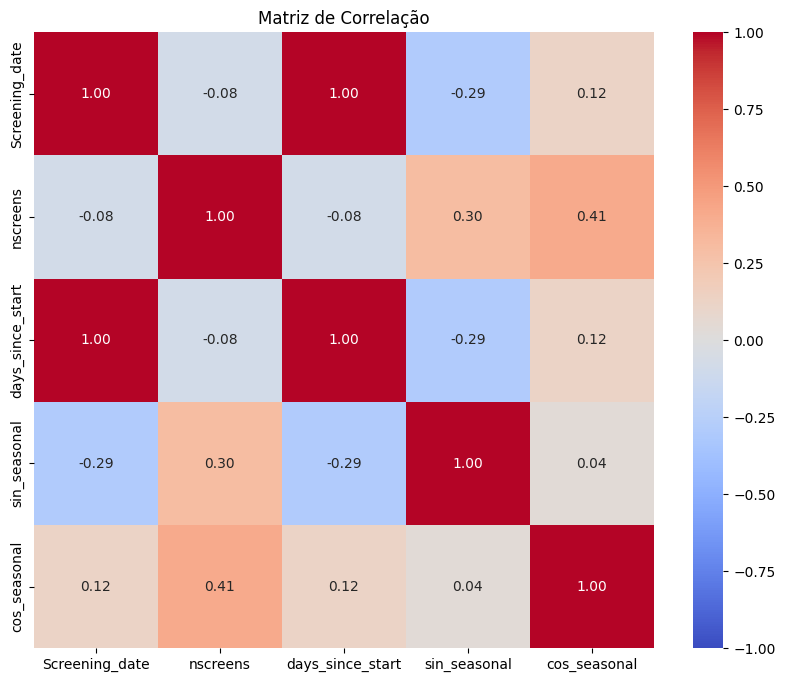

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de correlação
correlation_matrix = d4[['Screening_date','nscreens', 'days_since_start', 'sin_seasonal', 'cos_seasonal']].corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Plotar a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

# SARIMAX

In [5]:
# Dividir os dados em treino e teste
train_size = int(len(d4) * 0.8)  # Usar 80% dos dados para treino
train = d4.iloc[:train_size]
test = d4.iloc[train_size:]

# Definir as variáveis de treino e teste
y_train = train['nscreens']
X_train = train[['days_since_start', 'sin_seasonal', 'cos_seasonal']]
y_test = test['nscreens']
X_test = test[['days_since_start', 'sin_seasonal', 'cos_seasonal']]

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# Ajustar o modelo SARIMAX com dados de treino
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Previsão com dados de teste
forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Avaliar o modelo com métricas de desempenho
mae = mean_absolute_error(y_test, forecast_values)
mse = mean_squared_error(y_test, forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_values)
me = np.mean(y_test - forecast_values)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - forecast_values) / y_test))
rme = np.mean((y_test - forecast_values) / y_test)
rmae = np.mean(np.abs(y_test - forecast_values) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: SARIMA ")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SARIMA 
# MAE: 2.587979598386678
# MSE: 10.797161007843679
# RMSE: 3.2859033777400817
# R2: -1.847062915299889
# ME: 2.587979598386678
# MAV: 11.228988121444878
# MPV: 0.20377932207449226
# RME: 0.20377932207449226
# RMAE: 0.20377932207449226


Modelo: SARIMA 
MAE: 2.587979598386678
MSE: 10.797161007843679
RMSE: 3.2859033777400817
R2: -1.847062915299889
ME: 2.587979598386678
MAV: 11.228988121444878
MPV: 0.20377932207449226
RME: 0.20377932207449226
RMAE: 0.20377932207449226


Sem vv altamente corr - days_since_start

In [7]:
# Dividir os dados em treino e teste
train_size = int(len(d4) * 0.8)  # Usar 80% dos dados para treino
train = d4.iloc[:train_size]
test = d4.iloc[train_size:]

# Definir as variáveis de treino e teste
y_train = train['nscreens']
X_train = train[['sin_seasonal', 'cos_seasonal']]
y_test = test['nscreens']
X_test = test[['sin_seasonal', 'cos_seasonal']]

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# Ajustar o modelo SARIMAX com dados de treino
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Previsão com dados de teste
forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Avaliar o modelo com métricas de desempenho
mae = mean_absolute_error(y_test, forecast_values)
mse = mean_squared_error(y_test, forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_values)
me = np.mean(y_test - forecast_values)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - forecast_values) / y_test))
rme = np.mean((y_test - forecast_values) / y_test)
rmae = np.mean(np.abs(y_test - forecast_values) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: SARIMA ")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# SARIMAX SEM 'days_since_start'
# MAE: 2.0197811228082796
# MSE: 6.607635906861251
# RMSE: 2.5705322224903644
# R2: -0.74234274496437
# ME: 1.8998991254639106
# MAV: 11.228988121444878
# MPV: 0.1589387907985102
# RME: 0.14550631453201074
# RMAE: 0.1589387907985102


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo: SARIMA 
MAE: 2.0197811228082796
MSE: 6.607635906861251
RMSE: 2.5705322224903644
R2: -0.74234274496437
ME: 1.8998991254639106
MAV: 11.228988121444878
MPV: 0.1589387907985102
RME: 0.14550631453201074
RMAE: 0.1589387907985102
